# Experimenting with re-writing the model with PyMC3.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import emcee
import corner

import astropy.stats as aps
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates.builtin_frames.galactocentric \
    import get_matrix_vectors
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import aviary as av
import theano.tensor as tt

In [3]:
def deg_to_rad(deg):
    return deg * (2 * np.pi) / 360

# Solar coords
sun_xyz = [-8.122, 0, 0] * u.kpc
sun_vxyz = [12.9, 245.6, 7.78] * u.km/u.s

galcen_frame = coord.Galactocentric(galcen_distance=np.abs(sun_xyz[0]),
                                    galcen_v_sun=sun_vxyz,
                                    z_sun=0*u.pc)

# Pre-compute the rotation matrix to go from Galactocentric to ICRS
# (ra/dec) coordinates
R_gal, _ = get_matrix_vectors(galcen_frame, inverse=True)

ra_gc_deg, dec_gc_deg = 266.4051, -28.936175
ra_gc, dec_gc = deg_to_rad(np.array([ra_gc_deg, dec_gc_deg]))

eta_deg = 58.5986320306
eta = deg_to_rad(eta_deg)

d_gc = np.abs(sun_xyz[0]).value
zsun = 0

In [4]:
# # Calculate prior parameters from vx, vy, vz distributions.
# vels = pd.read_csv("../../data/gaia_lamost_mc_velocities.csv")
# m = (vels.rv.values != 0) * np.isfinite(vels.rv.values) * (vels.parallax.values > 0) * np.isfinite(vels.parallax.values)
# m &= np.isfinite(vels.basic_vx.values) * np.isfinite(vels.basic_vy.values) * np.isfinite(vels.basic_vz.values)
# vels = vels.iloc[m]

vels = pd.read_csv("../../data/gaia_mc5_velocities.csv")
m = vels.radial_velocity.values != 0
m &= np.isfinite(vels.basic_vx.values)
m &= np.isfinite(vels.basic_vy.values)
m &= np.isfinite(vels.basic_vz.values)
vels = vels.iloc[m]

# Calculate covariance between velocities
VX = np.stack((vels.basic_vx.values, vels.basic_vy.values,
               vels.basic_vz.values, np.log(1./vels.parallax.values)), axis=0)
mean = np.mean(VX, axis=1)
cov = np.cov(VX)

Matrix for calculating Galactocentric positions from equatorial coordinates.

In [5]:
def r_icrs_norm(ra_deg, dec_deg):
    ra, dec = deg_to_rad(np.array([ra_deg, dec_deg]))
    return np.array([[np.cos(ra) * np.cos(dec)],
                     [np.sin(ra) * np.cos(dec)],
                     [np.sin(dec)]])

def eqtogal(ra, dec, d):
    r = r_icrs_norm(ra, dec)
    R1 = np.array([[np.cos(dec_gc), 0, np.sin(dec_gc)],
                   [0, 1, 0],
                   [-np.sin(dec_gc), 0, np.cos(dec_gc)]])
    R2 = np.array([[np.cos(ra_gc), np.sin(ra_gc), 0],
                   [-np.sin(ra_gc), np.cos(ra_gc), 0],
                   [0, 0, 1]])
    R3 = np.array([[1, 0, 0],
                   [0, np.cos(eta), np.sin(eta)],
                   [0, -np.sin(eta), np.cos(eta)]])
    R1_R2 = np.dot(R1, R2)
    R = np.dot(R3, R1_R2)
    
    xhat = np.array([[1, 0, 0]]).T
    theta = np.arcsin(zsun/d_gc)
    H = np.array([[np.cos(theta), 0, np.sin(theta)],
                  [0, 1, 0],
                  [-np.sin(theta), 0, np.cos(theta)]])
    
    rdash = d * np.dot(R, r) - d_gc * xhat
    
    rgc = np.dot(H, rdash)
    return rgc

Code for converting km/s to mas/yr.

In [23]:
def cartesian_to_angular_units(km_s, kpc):
    to_yr = 365.2425 * 24 * 3600 * u.s/u.yr
    to_m = 1000 * u.m/u.km
    to_kpc = 1./3.0856775814671917e+19 * u.kpc/u.m
    to_deg = 360/(2*np.pi) * u.deg
    to_mas = 3600 * 1000 * u.mas/u.deg
    return km_s*u.km/u.s * to_m * to_yr * to_kpc / (kpc*u.kpc) * to_deg * to_mas

def cartesian_to_angular_no_units(km_s, kpc):
    to_yr = 365.2425 * 24 * 3600
    to_m = 1000
    to_kpc = 1./3.0856775814671917e+19
    to_deg = 360/(2*np.pi)
    to_mas = 3600 * 1000
    return km_s * to_m * to_yr * to_kpc / kpc * to_deg * to_mas

Test velocity to proper motion by starting with proper motion, transforming to velocity and back. 

In [7]:
# # Start with proper motion
# pos = [df["ra"], df["dec"], df["parallax"]]
# pos_err = [df["ra_error"], df["dec_error"], df["parallax_error"]]
# proper = [df["pmra"], df["pmdec"]]
# proper_err = [df["pmra_error"], df["pmdec_error"]]
# print("true proper motion = ", proper)

# # Transform to velocity.
# c = coord.SkyCoord(ra = pos[0]*u.deg,
#                    dec = pos[1]*u.deg,
#                    pm_ra_cosdec = proper[0]*u.mas/u.yr,
#                    pm_dec = proper[1]*u.mas/u.yr,
#                    radial_velocity=20*u.km/u.s,
#                    distance = D*u.kpc)
# g = c.transform_to(galcen_frame)


# params = [g.v_x.value, g.v_y.value, g.v_z.value, np.log(D)]
# pm_from_v, rv_from_v = av.proper_motion_model(params, pos)
# print("pm_from_v = ", pm_from_v)

# # Transform back

# dx = g.data.xyz - sun_xyz
# dv = params[:3]*u.km/u.s - sun_vxyz

# x_icrs = coord.ICRS(coord.CartesianRepresentation(R_gal @ dx))
# print("x_icrs.ra = ", x_icrs.ra)
# print("ra =", pos[0])
# M = get_tangent_basis(x_icrs.ra, x_icrs.dec)
# M = get_tangent_basis(pos[0] * 2*np.pi / 360., pos[1] * 2*np.pi / 360.)

# proj_dv = M @ R_gal @ dv
# pm = (proj_dv[:2] / (D*u.kpc)).to(u.mas/u.yr, u.dimensionless_angles())

# # vxyz = np.array([g.v_x.value, g.v_y.value, g.v_z.value])
# # pm = (vxyz*u.km/u.s / (D*u.kpc)).to(u.mas/u.yr, u.dimensionless_angles())

# print(pm)
# print(cartesian_to_angular_no_units(proj_dv[:2], D))

In [8]:
def get_tangent_basis(ra, dec):
    """
    row vectors are the tangent-space basis at (alpha, delta, r)
    ra, dec in radians
    """

    # Precompute this matrix and save for each star.
    M = np.array([
        [-np.sin(ra), np.cos(ra), 0.],
        [-np.sin(dec)*np.cos(ra), -np.sin(dec)*np.sin(ra), np.cos(dec)],
        [np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)]
    ])
    return M


def get_icrs_from_galactocentric(xyz, vxyz, ra, dec, distance):

    # Parameters
    dx = xyz - sun_xyz.value
    dv = vxyz - sun_vxyz.value
    
    # M is precomputed for each star, R_gal is same matrix, so just do this
    # dot product.
    proj_dv = M @ R_gal @ dv
        
    # Calculate the unit conversion using 1kms/1km and transform.
    proper = cartesian_to_angular_no_units(proj_dv[:2], distance)
    rv = proj_dv[2]
    return proper, rv


# This works!
def get_icrs_from_galactocentric_tt(xyz, vxyz, ra, dec, distance):

    vxyz = vxyz*u.km/u.s
    
    # Calculate XYZ position from ra, dec and parallax
    c = coord.SkyCoord(ra = pos[0]*u.deg,
                       dec = pos[1]*u.deg,
                       distance = D*u.kpc)
    galcen = c.transform_to(galcen_frame)
    xyz = galcen.data.xyz
    
    # Parameters
    dx = xyz - sun_xyz
    dv = vxyz - sun_vxyz

    # Don't need this as already have ra and dec.
    x_icrs = coord.ICRS(
        coord.CartesianRepresentation(R_gal @ dx))

    M = get_tangent_basis(x_icrs.ra, x_icrs.dec)

    # M is precomputed for each star, R_gal is same matrix, so just do this
    # dot product.
    proj_dv = M @ R_gal @ dv

    # Calculate the unit conversion using 1kms/1km and transform.
    pm = (proj_dv[:2] / x_icrs.distance).to(u.mas/u.yr,
                                            u.dimensionless_angles())

    rv = proj_dv[2]

    return pm.value, rv.value

In [9]:
def lnlike_one_star(params, pm, pm_err, pos, pos_err):

    # Unpack parameters and make distance linear.
    vx, vy, vz, lnD = params
    D = np.exp(lnD)

    xyz = eqtogal(pos[0], pos[1], D)

    # Calculate pm and rv from XYZ and V_XYZ
    vxyz = [vx, vy, vz]
    pm_from_v, rv_from_v = get_icrs_from_galactocentric(xyz[:, 0], vxyz, pos[0], pos[1], D)

    return -.5*(pm_from_v[0].value - pm[0])**2/pm_err[0]**2 \
           -.5*(pm_from_v[1].value - pm[1])**2/pm_err[1]**2 \
           -.5*(1./D - pos[2])**2/pos_err[2]**2


def multivariate_lngaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return -fac / 2 - np.log(N)


def lnprior(params):
    vx, vy, vz, lnD = params
    pos = np.stack((vx, vy, vz, lnD))
    return float(multivariate_lngaussian(pos, mean, cov))


def lnprob(params, pm, pm_err, pos, pos_err):
    return lnlike_one_star(params, pm, pm_err, pos, pos_err) + lnprior(params)

In [10]:
# Format parameter and data arrays.
df = vels.iloc[0]

pos = [df["ra"], df["dec"], df["parallax"]]
pos_err = [df["ra_error"], df["dec_error"], df["parallax_error"]]
proper = [df["pmra"], df["pmdec"]]
proper_err = [df["pmra_error"], df["pmdec_error"]]
inits = [df["basic_vx"], df["basic_vy"], df["basic_vz"],
         np.log(1./df["parallax"])]

In [11]:
from astropy.coordinates import SkyCoord

# Try a star with position at the galactic pole.
c = SkyCoord('12h51.4m', '+27.13',  unit=(u.hourangle, u.deg), frame='icrs')
pos[0] = c.ra.value
pos[1] = c.dec.value

In [12]:
M = get_tangent_basis(pos[0] * 2*np.pi/360, pos[1] * 2*np.pi/360)
# M = get_tangent_basis(pos[0], pos[1])

Test lhf.

In [13]:
lnlike_one_star(inits, proper, proper_err, pos, pos_err)

-1659841.1295394471

In [17]:
# Run MCMC.
ndim, nwalkers = 4, 16
p0 = np.random.randn(nwalkers, ndim)*1e-2 + inits
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                args=(proper, proper_err, pos, pos_err))

# This works!
# sampler = emcee.EnsembleSampler(nwalkers, ndim, av.lnprob,
#                                 args=(proper, proper_err, pos, pos_err))

nsteps = 1000
sampler.run_mcmc(p0, nsteps, progress=True);

# Extract inferred parameters and uncertainties.
flat_samples = sampler.get_chain(discard=int(nsteps/2), flat=True)
params_inferred = np.median(flat_samples, axis=0)

100%|██████████| 1000/1000 [00:09<00:00, 103.52it/s]


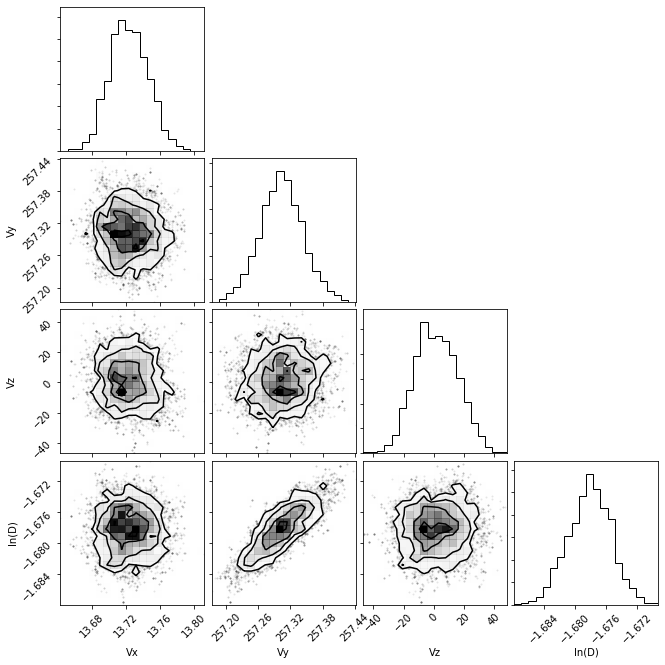

In [18]:
labels=["Vx", "Vy", "Vz", "ln(D)"]
fig = corner.corner(flat_samples, labels=labels);

Now try to rewrite this in PyMC3...

Write functions in theano.

In [19]:
import theano.tensor as tt

def tt_r_icrs_norm(ra_deg, dec_deg):
    ra, dec = deg_to_rad(np.array([ra_deg, dec_deg]))
    return np.array([[np.cos(ra) * np.cos(dec)],
                     [np.sin(ra) * np.cos(dec)],
                     [np.sin(dec)]])

np.random.seed(42)
ntest = 100
ra_tests = np.random.uniform(0, 360, ntest)
dec_tests = np.random.uniform(-90, 90, ntest)
d_tests = np.random.uniform(0, 10, ntest)
for i in range(ntest):
    _xtt, _ytt, _ztt = tt_r_icrs_norm(ra_tests[i], dec_tests[i])
    _x, _y, _z = r_icrs_norm(ra_tests[i], dec_tests[i])
    assert _xtt == _x
    assert _ytt == _y
    assert _ztt == _z

In [20]:
def tt_eqtogal(ra, dec, d):
    r = tt_r_icrs_norm(ra, dec)
    R1 = np.array([[np.cos(dec_gc), 0, np.sin(dec_gc)],
                   [0, 1, 0],
                   [-np.sin(dec_gc), 0, np.cos(dec_gc)]])
    R2 = np.array([[np.cos(ra_gc), np.sin(ra_gc), 0],
                   [-np.sin(ra_gc), np.cos(ra_gc), 0],
                   [0, 0, 1]])
    R3 = np.array([[1, 0, 0],
                   [0, np.cos(eta), np.sin(eta)],
                   [0, -np.sin(eta), np.cos(eta)]])
    R1_R2 = np.dot(R1, R2)
    R = np.dot(R3, R1_R2)
    
    xhat = np.array([[1, 0, 0]]).T
    theta = np.arcsin(zsun/d_gc)
    H = np.array([[np.cos(theta), 0, np.sin(theta)],
                  [0, 1, 0],
                  [-np.sin(theta), 0, np.cos(theta)]])
    
    rdash = d * np.dot(R, r) - d_gc * xhat
    
    rgc = tt.dot(H, rdash)
    return rgc

np.random.seed(42)
for i in range(ntest):
    rgc = tt_eqtogal(ra_tests[i], dec_tests[i], d_tests[i])
    _xtt, _ytt, _ztt = rgc.eval()
    _x, _y, _z = eqtogal(ra_tests[i], dec_tests[i], d_tests[i])
    assert _xtt == _x
    assert _ytt == _y
    assert _ztt == _z

In [22]:
# def tt_cartesian_to_angular_no_units(km_s, kpc):
#     to_km_yr = 365.2425 * 24*3600
#     to_m_yr = 1000
#     to_kpc_yr = 1./3.0856775814671917e+19
#     to_rad_yr = 1./kpc
#     to_deg_yr = 360/(2*np.pi)
#     to_mas_yr = 3600*1000
#     return tt.arcsin((km_s * to_km_yr) * to_m_yr * to_kpc_yr * to_rad_yr) * to_deg_yr * to_mas_yr

# np.random.seed(42)
# v_tests = np.random.uniform(-50, 50, ntest)
# for i in range(ntest):
#     masyrtt = tt_cartesian_to_angular_no_units(v_tests[i], d_tests[i]).eval()
#     masyr = cartesian_to_angular_no_units(v_tests[i], d_tests[i])
#     assert masyrtt == masyr

In [24]:
def tt_get_icrs_from_galactocentric(xyz, vxyz, ra, dec, distance):
    dx = xyz - sun_xyz.value
    dv = vxyz - sun_vxyz.value

    # M is precomputed for each star, R_gal is same matrix, so just do this
    # dot product.
    proj_dv = tt.dot(M, tt.dot(R_gal, dv))
        
    # Calculate the unit conversion using 1kms/1km and transform.
    proper = cartesian_to_angular_no_units(proj_dv[:2], distance)

    rv = proj_dv[2]

    return proper, rv

np.random.seed(42)
vx_tests, vy_tests, vz_tests = [np.random.uniform(-100, 100, ntest) for i in range(3)]
for i in range(ntest):
    _vxyz = np.array([vx_tests[i], vy_tests[i], vz_tests[i]])
    vxyz = tt.as_tensor_variable(_vxyz)
    rgc = tt_eqtogal(ra_tests[i], dec_tests[i], d_tests[i])
    xyz = tt.as_tensor_variable(rgc.eval())
    pmtt, rvtt = tt_get_icrs_from_galactocentric(rgc.eval(), _vxyz, ra_tests[i], dec_tests[i], d_tests[i])
    pm, rv = get_icrs_from_galactocentric(rgc.eval(), _vxyz, ra_tests[i], dec_tests[i], d_tests[i])
    assert np.isclose(pmtt.eval()[0], pm[0], atol=1e-16)
    assert np.isclose(pmtt.eval()[1], pm[1], atol=1e-16)
    assert np.isclose(rvtt.eval(), rv, atol=1e-16)

In [25]:
# vxyz = tt.as_tensor_variable(np.array([10.0, 15.0, 250.0]))
# D = tt.as_tensor_variable(1.23)
# xyz = tt_eqtogal(pos[0], pos[1], D)
# xyz.eval()

# pm_from_v, rv_from_v = tt_get_icrs_from_galactocentric(xyz[:, 0], vxyz, pos[0], pos[1], D)
# print(pos, D)

In [ ]:
import pymc3 as pm
import exoplanet as xo

with pm.Model() as model:
    
    vxyzD = pm.MvNormal("vxyzD", mu=mean, cov=cov, shape=4)
    vxyz = pm.Deterministic("vxyz", vxyzD[:3])
    log_D = pm.Deterministic("log_D", vxyzD[3])
    D = pm.Deterministic("D", tt.exp(log_D))
    
    xyz = pm.Deterministic("xyz", tt_eqtogal(pos[0], pos[1], D)[:, 0])
          
    pm_from_v, rv_from_v = tt_get_icrs_from_galactocentric(xyz, vxyz, pos[0], pos[1], D)
    
    pm.Normal("proper_motion", mu=pm_from_v, sigma=np.array(proper_err), observed=np.array(proper))
    pm.Normal("parallax", mu=1. / D, sigma=pos_err[2], observed=pos[2])
    
    map_soln = xo.optimize()
    trace = pm.sample(tune=1500, draws=1000, start=map_soln, step=xo.get_dense_nuts_step(target_accept=0.9))

optimizing logp for variables: [vxyzD]
45it [00:00, 393.59it/s, logp=-5.124998e+00] 
message: Optimization terminated successfully.
logp: -326389.8616708397 -> -5.124998308087761
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vxyzD]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:08<00:00, 1217.66draws/s]


In [37]:
model

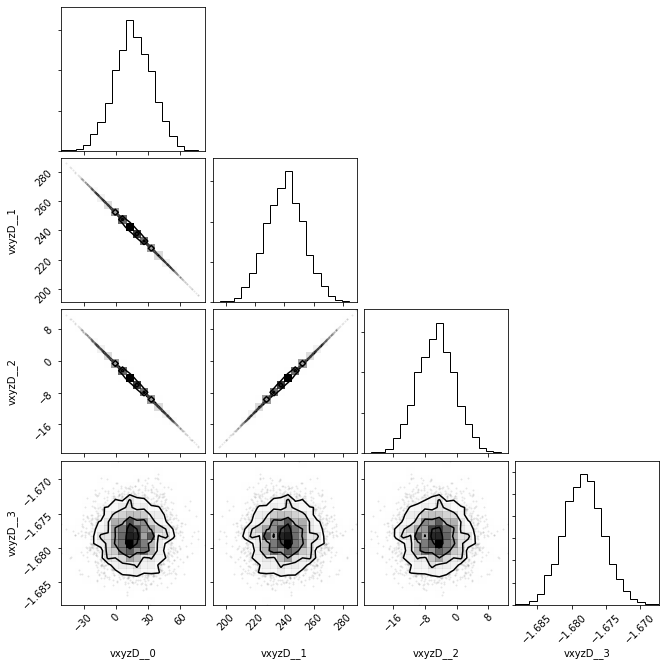

In [38]:
samples = pm.trace_to_dataframe(trace)
corner.corner(samples.iloc[:, :4]);

In [104]:
pos

[192.85, 27.13, 8.899751332953752]